In [1]:
#IMPORT LIBRARIES
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("datasets/cleandf.csv")

In [3]:
df.sample()

,Unnamed: 0,AIRLINENAME,CABINTYPE,DATEFLOWN,DATEPUB,ENTERTAINMENTRATING,FOODRATING,GROUNDSERVICERATING,ORIGINCOUNTRY,OVERALLSCORE,...,SLUG,TITLE,TRAVELLER,PURPOSE,TRIPVERIFIED,VALUERATING,WIFIRATING,UNIQUE_ID,LONGDISTANCE,YEAR
13275,13322,Allegiant Air,2,2016-12-01,2nd January 2017,1,1,1,UnitedStates,1,...,allegiant-air,no more flying this airline,2,1,0,1,0,556e4022-6f27-402b-be2a-b3da8567a867,1,2016


In [4]:
df=df.drop(columns="Unnamed: 0")

In [5]:
pd.set_option('display.max_columns', None)

## OLS regression

Purpose: check the effect of independent variables on the overallscore (dep. variable)

In [6]:
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error,r2_score

In [7]:
olsmodel=df.copy()

In [8]:
olsmodel.sample()

,AIRLINENAME,CABINTYPE,DATEFLOWN,DATEPUB,ENTERTAINMENTRATING,FOODRATING,GROUNDSERVICERATING,ORIGINCOUNTRY,OVERALLSCORE,RECOMMENDED,REVIEW,ROUTE,ORIGIN,DESTINY,SCALE_YN,SEATCOMFORTRATING,SERVICERATING,SLUG,TITLE,TRAVELLER,PURPOSE,TRIPVERIFIED,VALUERATING,WIFIRATING,UNIQUE_ID,LONGDISTANCE,YEAR
6113,Air Tahiti Nui,3,2017-02-01,4th February 2017,2,2,1,France,2,0,We booked Air New Zealand London to Papeete vi...,Papeete to Los Angeles,Papeete,Los Angeles,0,2,2,air-tahiti-nui,experience not to be renewed,1,0,0,2,0,1bedd662-792e-486c-8866-f12655d2aaae,1,2017


In [9]:
#include the year variable

from datetime import datetime

olsmodel['DATEFLOWN'] = pd.to_datetime(olsmodel['DATEFLOWN'],  format='mixed')

In [10]:
olsmodel.PURPOSE.value_counts() #quite imbalanced!


PURPOSE
1    76015
0    13993
Name: count, dtype: int64

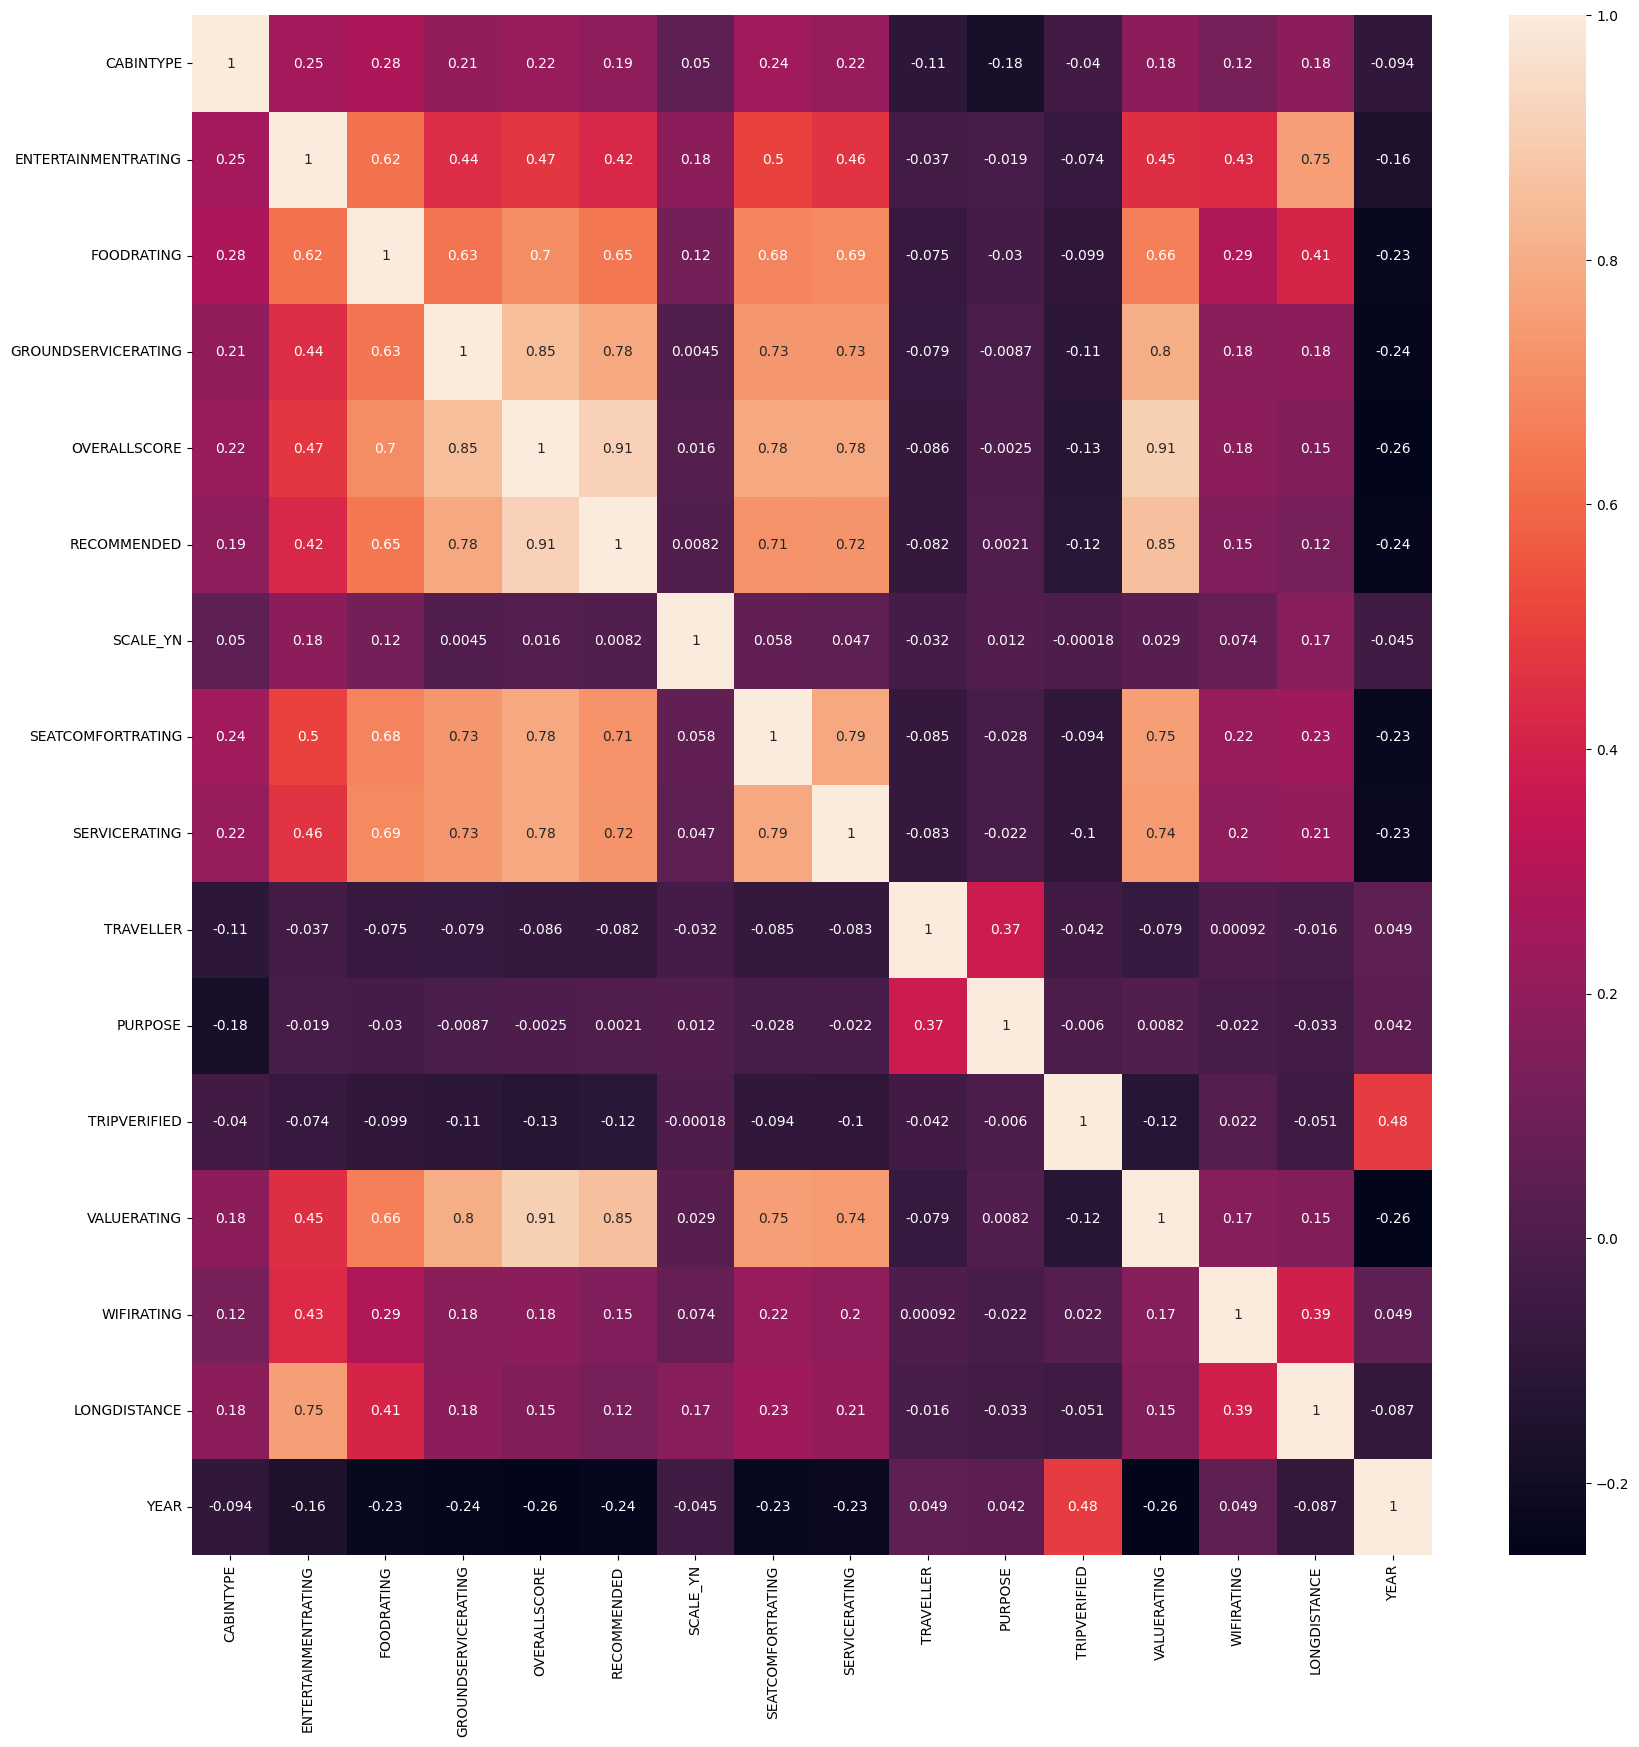

In [11]:
data_corr = olsmodel.select_dtypes(np.number)
corr_matrix=data_corr.corr(method='pearson')
fig, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [12]:
#quite a lot of multicollinearity, let's drop some variables, those with highest multicoll.
olsmodel.drop(columns="ENTERTAINMENTRATING", inplace=True)
olsmodel.drop(columns="VALUERATING", inplace=True)
olsmodel.drop(columns="RECOMMENDED", inplace=True)
olsmodel.drop(columns="SEATCOMFORTRATING", inplace=True)
olsmodel.drop(columns="GROUNDSERVICERATING", inplace=True)
olsmodel.drop(columns="FOODRATING", inplace=True)
olsmodel.drop(columns="WIFIRATING", inplace=True)

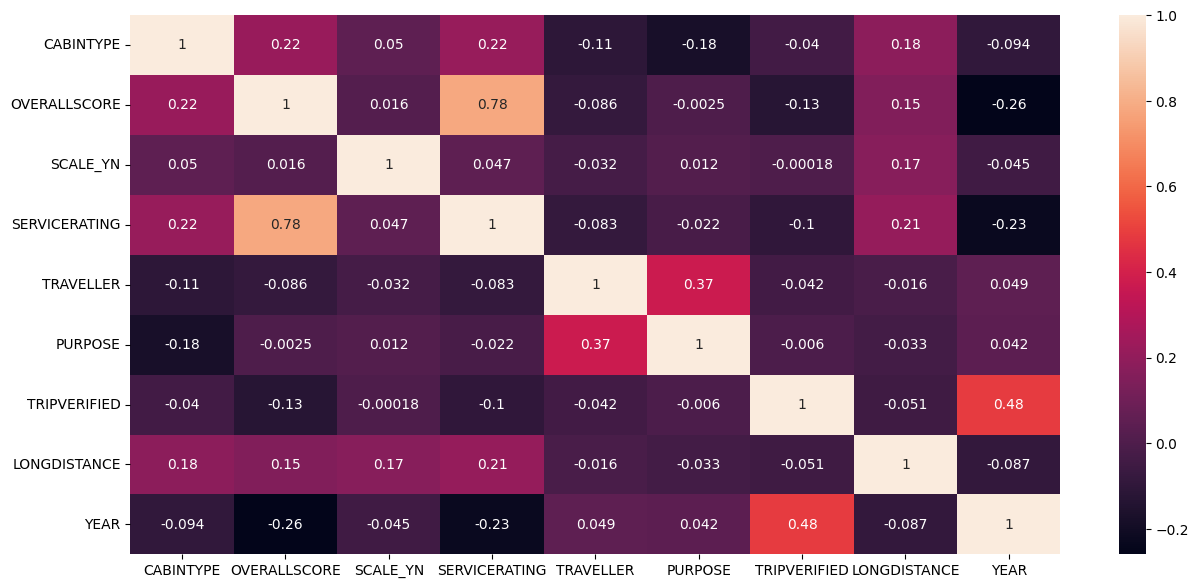

In [13]:
data_corr = olsmodel.select_dtypes(np.number)
corr_matrix=data_corr.corr(method='pearson')
fig, ax = plt.subplots(figsize=(15, 7))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [14]:
#check those with highest correlation (below 0.9)
from scipy.stats import chi2_contingency
data_crosstab = pd.crosstab(olsmodel['SERVICERATING'], olsmodel['OVERALLSCORE'], margins = False)
data_crosstab 
chi2_contingency(data_crosstab, correction=False)


Chi2ContingencyResult(statistic=81737.54393269491, pvalue=0.0, dof=45, expected_freq=array([[ 2803.86396765,   672.69978224,   397.45531508,   222.31283886,
          212.44667141,   192.42627322,   319.17411786,   485.53066394,
          530.39652031,   645.69384944],
       [11496.18831659,  2758.15213092,  1629.61584526,   911.51007688,
          871.05757266,   788.9714692 ,  1308.65327526,  1990.73564572,
         2174.69119412,  2647.42447338],
       [ 4561.36154564,  1094.35655719,   646.58535908,   361.66135232,
          345.61094569,   313.04150742,   519.23651231,   789.86745623,
          862.85580171,  1050.4229624 ],
       [ 5381.4982446 ,  1291.1228002 ,   762.84195849,   426.68837214,
          407.7520887 ,   369.32663763,   612.59568038,   931.886299  ,
         1017.99801129,  1239.28990756],
       [ 5464.55006222,  1311.04849569,   774.61477869,   433.27338681,
          414.04486268,   375.02639765,   622.04977335,   946.26795396,
         1033.70861479,  1258.4

In [15]:
model = LinearRegression().fit(olsmodel[['OVERALLSCORE']], olsmodel[['SERVICERATING']])
model.score(olsmodel[['OVERALLSCORE']], olsmodel[['SERVICERATING']]) #0.6 is not that much, keep it as it explain the Y!

0.6108039523027049

In [16]:
#VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables=data_corr.copy()
variables.drop(columns="OVERALLSCORE", inplace=True)
vif_data=pd.DataFrame()
vif_data["Variable"]=variables.columns
vif_data["VIF"]=[variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif_data

#YEAR still very correlated

,Variable,VIF
0,CABINTYPE,4.581462
1,SCALE_YN,1.400094
2,SERVICERATING,3.804462
3,TRAVELLER,6.410870
4,PURPOSE,7.655578
5,TRIPVERIFIED,2.042962
6,LONGDISTANCE,2.482620
7,YEAR,17.328587


In [17]:
print(olsmodel["YEAR"].min()) 
print(olsmodel["YEAR"].max())

2012
2023


In [18]:
olsmodel.drop(columns="YEAR", inplace=True)

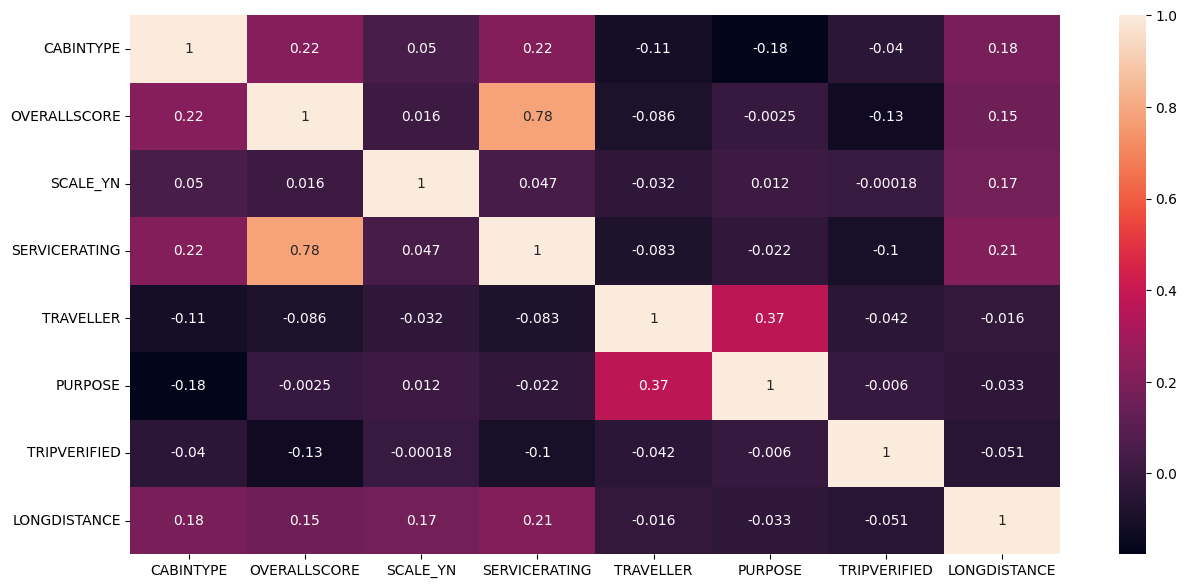

In [19]:
data_corr = olsmodel.select_dtypes(np.number)
corr_matrix=data_corr.corr(method='pearson')
fig, ax = plt.subplots(figsize=(15, 7))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [20]:
#VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables=data_corr.copy()
variables.drop(columns="OVERALLSCORE", inplace=True)
vif_data=pd.DataFrame()
vif_data["Variable"]=variables.columns
vif_data["VIF"]=[variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif_data
#ok now!

,Variable,VIF
0,CABINTYPE,3.652302
1,SCALE_YN,1.389508
2,SERVICERATING,3.454031
3,TRAVELLER,5.454421
4,PURPOSE,6.044855
5,TRIPVERIFIED,1.833495
6,LONGDISTANCE,2.438742


In [21]:
olsmodel.shape

(90008, 19)

In [22]:
olsmodel.sample()

,AIRLINENAME,CABINTYPE,DATEFLOWN,DATEPUB,ORIGINCOUNTRY,OVERALLSCORE,REVIEW,ROUTE,ORIGIN,DESTINY,SCALE_YN,SERVICERATING,SLUG,TITLE,TRAVELLER,PURPOSE,TRIPVERIFIED,UNIQUE_ID,LONGDISTANCE
69158,Spirit Airlines,1,2020-08-01,11th June 2021,UnitedStates,1,Fort Lauderdale to Montego Bay. Run! Do not fl...,Fort Lauderdale to Montego Bay,Fort Lauderdale,Montego Bay,0,1,spirit-airlines,lacks integrity and customer service,2,1,1,a2940d9e-d4be-4951-8c9d-21bba7678b30,1


In [23]:
x_regression = data_corr.drop(columns=['OVERALLSCORE'])

In [24]:
Y=data_corr.OVERALLSCORE

In [25]:
X_train, X_test, y_train, y_test = train_test_split(x_regression, Y, test_size=0.8, random_state=42)

In [26]:
x_regression.sample()

,CABINTYPE,SCALE_YN,SERVICERATING,TRAVELLER,PURPOSE,TRIPVERIFIED,LONGDISTANCE
1607,1,1,1,2,1,1,1


In [27]:
lm=linear_model.LinearRegression()
model=lm.fit(X_train, y_train)

predictions=lm.predict(X_train)
r2=r2_score(y_train, predictions)
print(r2)


0.6153326661765446


In [28]:
lm=linear_model.LinearRegression()
model=lm.fit(X_train, y_train)

predictions=lm.predict(X_test)
r2=r2_score(y_test, predictions)
print(r2)

0.6185533373477092


In [29]:
X_train_sm = sm.add_constant(X_train)
model = sm.OLS(y_train,X_train_sm).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           OVERALLSCORE   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     4112.
Date:                Sun, 07 Jul 2024   Prob (F-statistic):               0.00
Time:                        12:39:33   Log-Likelihood:                -39115.
No. Observations:               18001   AIC:                         7.825e+04
Df Residuals:                   17993   BIC:                         7.831e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2670      0.066     -4.034

In [30]:
#let's standardise to check if we get better results
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(x_regression)

# Now, all features will have the same weight.
pd.DataFrame(X_scaled).head()

,0,1,2,3,4,5,6
0,-0.432271,-0.597403,1.347142,-0.868027,0.429048,0.994394,-1.122309
1,-0.432271,-0.597403,-0.402818,-0.868027,0.429048,0.994394,-1.122309
2,-0.432271,-0.597403,-0.986138,-0.868027,0.429048,0.994394,-1.122309
3,-0.432271,-0.597403,0.180502,-0.868027,-2.330742,0.994394,-1.122309
4,-0.432271,-0.597403,0.763822,-0.868027,0.429048,0.994394,-1.122309


In [31]:
X_standarised = pd.DataFrame(X_scaled, columns = x_regression.columns)

In [32]:
X_standarised.sample()

,CABINTYPE,SCALE_YN,SERVICERATING,TRAVELLER,PURPOSE,TRIPVERIFIED,LONGDISTANCE
79640,-0.432271,-0.597403,-0.986138,-0.868027,-2.330742,0.994394,0.89102


In [33]:
X_standarised.reset_index(drop=True, inplace=True)

In [34]:
Y.reset_index(drop=True, inplace=True)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_standarised, Y, test_size=0.8, random_state=42)

In [36]:
X = sm.add_constant(X_train)
model = sm.OLS(y_train,X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           OVERALLSCORE   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     4112.
Date:                Sun, 07 Jul 2024   Prob (F-statistic):               0.00
Time:                        12:39:33   Log-Likelihood:                -39115.
No. Observations:               18001   AIC:                         7.825e+04
Df Residuals:                   17993   BIC:                         7.831e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.9706      0.016    250.549

In [37]:
lm=linear_model.LinearRegression()
model=lm.fit(X_train, y_train)

predictions=lm.predict(X_train)
r2=r2_score(y_train, predictions)
print(r2)

0.6153326661765445


In [38]:
lm=linear_model.LinearRegression()
model=lm.fit(X_train, y_train)

predictions=lm.predict(X_test)
r2=r2_score(y_test, predictions)
print(r2)

0.6185533373477092


In [39]:
#Regression using KNN (to avoid multicollinearity)

In [40]:
from sklearn.neighbors import KNeighborsRegressor 

In [41]:
knnreg=KNeighborsRegressor(n_neighbors=15)
knnreg.fit(X_train, y_train) #already standarised

KNeighborsRegressor(n_neighbors=15)

In [42]:
knnregpred=knnreg.predict(X_test)

In [43]:
r2_knnreg=r2_score(y_test, knnregpred)
print(r2,r2_knnreg) #gets better with knn!

0.6185533373477092 0.6485631466177874


In [44]:
#Do the GridSearch:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
param_grid = {
    'n_neighbors': [30, 35, 40, 45, 50, 60],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

In [45]:
grid_search = GridSearchCV(estimator= KNeighborsRegressor(), param_grid=param_grid, cv=5, scoring='r2')

In [46]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                         'n_neighbors': [30, 35, 40, 45, 50, 60],
                         'weights': ['uniform', 'distance']},
             scoring='r2')

In [47]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [48]:
best_params

{'algorithm': 'auto', 'n_neighbors': 60, 'weights': 'distance'}

In [49]:
best_score 

0.655420067933246

In [50]:
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)

print("R2 with KNN Regressor is: ", test_score)

R2 with KNN Regressor is:  0.661556141945469


In [51]:
knnmodel=KNeighborsRegressor(n_neighbors=60,weights='distance', algorithm='auto')
knnmodel.fit(X_train, y_train)


KNeighborsRegressor(n_neighbors=60, weights='distance')

In [52]:
knnprediction=knnmodel.predict(X_test)

In [53]:
r2_knn=r2_score(y_test, knnprediction)

In [54]:
print(r2_knn)
print(r2,r2_knn) #gets better with knn!

0.661556141945469
0.6185533373477092 0.661556141945469


In [55]:
knnprediction=knnmodel.predict(X_train)

In [56]:
r2_knn=r2_score(y_train, knnprediction)

In [57]:
print(r2_knn)
print(r2,r2_knn) #not overfitting!

0.6831682523694642
0.6185533373477092 0.6831682523694642


In [58]:
# Including more variables, as here we can avoid multicollinearity:

In [59]:
df.sample()

,AIRLINENAME,CABINTYPE,DATEFLOWN,DATEPUB,ENTERTAINMENTRATING,FOODRATING,GROUNDSERVICERATING,ORIGINCOUNTRY,OVERALLSCORE,RECOMMENDED,REVIEW,ROUTE,ORIGIN,DESTINY,SCALE_YN,SEATCOMFORTRATING,SERVICERATING,SLUG,TITLE,TRAVELLER,PURPOSE,TRIPVERIFIED,VALUERATING,WIFIRATING,UNIQUE_ID,LONGDISTANCE,YEAR
84922,United Airlines,1,2020-12-01,21st January 2021,1,1,1,UnitedStates,1,0,United delayed us for nearly 9 hours on a one-...,Oklahoma City to Tampa via Houston,Oklahoma City,Tampa,1,1,1,united-airlines,United delayed us for nearly 9 hours on a one-...,2,1,0,1,1,d73d9f67-8ba5-4f78-863c-365416990fa9,1,2020


In [60]:
knn2=df.copy()

In [61]:
knnregmodel=knn2[["CABINTYPE", "OVERALLSCORE", "SCALE_YN", "SERVICERATING", "SEATCOMFORTRATING","FOODRATING", "GROUNDSERVICERATING", "TRAVELLER","PURPOSE", "TRIPVERIFIED","LONGDISTANCE"]]

In [62]:
knnregmodel

,CABINTYPE,OVERALLSCORE,SCALE_YN,SERVICERATING,SEATCOMFORTRATING,FOODRATING,GROUNDSERVICERATING,TRAVELLER,PURPOSE,TRIPVERIFIED,LONGDISTANCE
0,1,9,0,5,4,4,4,1,1,1,0
1,1,1,0,2,2,1,1,1,1,1,0
2,1,1,0,1,2,1,1,1,1,1,0
3,1,2,0,3,1,1,1,1,0,1,0
4,1,9,0,4,4,0,5,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
90003,1,8,0,1,1,0,2,1,1,0,0
90004,1,1,0,2,1,1,1,3,1,0,1
90005,1,1,0,1,2,0,2,1,1,0,0
90006,1,1,0,2,2,0,1,2,1,0,0


In [63]:
knnregmodel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90008 entries, 0 to 90007
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   CABINTYPE            90008 non-null  int64
 1   OVERALLSCORE         90008 non-null  int64
 2   SCALE_YN             90008 non-null  int64
 3   SERVICERATING        90008 non-null  int64
 4   SEATCOMFORTRATING    90008 non-null  int64
 5   FOODRATING           90008 non-null  int64
 6   GROUNDSERVICERATING  90008 non-null  int64
 7   TRAVELLER            90008 non-null  int64
 8   PURPOSE              90008 non-null  int64
 9   TRIPVERIFIED         90008 non-null  int64
 10  LONGDISTANCE         90008 non-null  int64
dtypes: int64(11)
memory usage: 7.6 MB


In [64]:
x_reg= knnregmodel.drop(columns='OVERALLSCORE')

In [65]:
Y=knnregmodel.OVERALLSCORE

In [66]:
#in knn essential to standarise in order to have same metrics therefore same distance between the values!
X_scaled = StandardScaler().fit_transform(x_reg)

# Now, all features will have the same weight.
pd.DataFrame(X_scaled).head()

,0,1,2,3,4,5,6,7,8,9
0,-0.432271,-0.597403,1.347142,0.992817,1.214641,1.010415,-0.868027,0.429048,0.994394,-1.122309
1,-0.432271,-0.597403,-0.402818,-0.291398,-0.499985,-0.822756,-0.868027,0.429048,0.994394,-1.122309
2,-0.432271,-0.597403,-0.986138,-0.291398,-0.499985,-0.822756,-0.868027,0.429048,0.994394,-1.122309
3,-0.432271,-0.597403,0.180502,-0.933506,-0.499985,-0.822756,-0.868027,-2.330742,0.994394,-1.122309
4,-0.432271,-0.597403,0.763822,0.992817,-1.071527,1.621472,-0.868027,0.429048,0.994394,-1.122309


In [67]:
X_standarised = pd.DataFrame(X_scaled, columns = x_reg.columns)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_standarised, Y, test_size=0.2, stratify=Y, random_state=42)

In [69]:
#Do the GridSearch:

param_grid = {
    'n_neighbors': [30, 35, 40, 45, 50, 60],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

In [70]:
grid_search = GridSearchCV(estimator= KNeighborsRegressor(), param_grid=param_grid, cv=5, scoring='r2')

In [71]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                         'n_neighbors': [30, 35, 40, 45, 50, 60],
                         'weights': ['uniform', 'distance']},
             scoring='r2')

In [72]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [73]:
best_params

{'algorithm': 'auto', 'n_neighbors': 45, 'weights': 'uniform'}

In [74]:
best_score

0.854650488296406

In [75]:
model2=KNeighborsRegressor(n_neighbors=45,weights='uniform', algorithm='auto')
model2.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=45)

In [76]:
prediction2=model2.predict(X_test)

In [77]:
r2_2=r2_score(y_test, prediction2)

In [78]:
print(r2_2)

0.8547602215981129


In [79]:
from sklearn.model_selection import cross_val_score

In [80]:
cross_val_score(model2, X_train, y_train, cv=10) 

array([0.85215132, 0.86265378, 0.85472727, 0.85023045, 0.86329515,
       0.84901125, 0.85577096, 0.85484645, 0.85375861, 0.85297085])

In [81]:
#in knn essential to standarise in order to have same metrics therefore same distance between the values!
X_scaled = StandardScaler().fit_transform(x_reg)

# Now, all features will have the same weight.
pd.DataFrame(X_scaled).head()

,0,1,2,3,4,5,6,7,8,9
0,-0.432271,-0.597403,1.347142,0.992817,1.214641,1.010415,-0.868027,0.429048,0.994394,-1.122309
1,-0.432271,-0.597403,-0.402818,-0.291398,-0.499985,-0.822756,-0.868027,0.429048,0.994394,-1.122309
2,-0.432271,-0.597403,-0.986138,-0.291398,-0.499985,-0.822756,-0.868027,0.429048,0.994394,-1.122309
3,-0.432271,-0.597403,0.180502,-0.933506,-0.499985,-0.822756,-0.868027,-2.330742,0.994394,-1.122309
4,-0.432271,-0.597403,0.763822,0.992817,-1.071527,1.621472,-0.868027,0.429048,0.994394,-1.122309


In [82]:
X_standarised = pd.DataFrame(X_scaled, columns = x_reg.columns)

In [83]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
pca=PCA()
pca.fit(X_standarised)

pca.explained_variance_ratio_ 

array([0.34042901, 0.14181668, 0.11371295, 0.09847361, 0.08791546,
       0.07690618, 0.06046773, 0.03186174, 0.02731597, 0.02110068])

In [84]:
variations=pca.explained_variance_ratio_*100
variations=np.round(variations, decimals=1)

<module 'matplotlib.pyplot' from 'c:\\Users\\Aida\\anaconda3\\envs\\ironhack\\Lib\\site-packages\\matplotlib\\pyplot.py'>

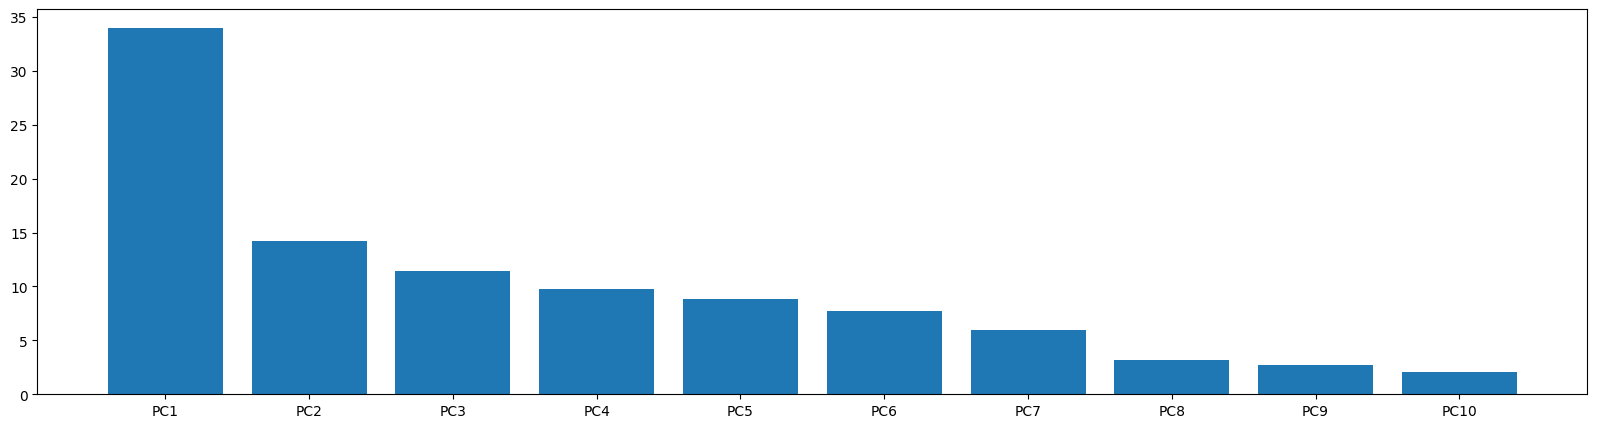

In [85]:
plot_labels=["PC"+str(i) for i in range(1, len(variations)+1)] #es de 1 en adealnte para que la posición 1 no se llame posición 0 que es un lío
from matplotlib.pyplot import figure
figure(figsize=(20,5))
plt.bar(x=plot_labels, height=variations)
plt